In [1]:
import roboflow

ROBOFLOW_ROOT_DIR = './.data/robo'

roboflow.login()
rf = roboflow.Roboflow()

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).


# Test COCO Project format

In [2]:
from robowrapper import RoboCOCODataset
from robowrapper import RoboProjCreator

p = '/Users/n0c09jf/Downloads/wider_face_robo/fer_wider_face_template_v1'
ds_p = RoboCOCODataset(p)

proj_test = RoboProjCreator(rf, proj_name='test1').create()
proj_test.upload(ds_p)

loading Roboflow workspace...


loading Roboflow project...
Duplicate image not uploaded: /Users/n0c09jf/Downloads/wider_face_robo/fer_wider_face_template_v1/test/fer_wider_face_sample_jpg.rf.5bced443620d61f66d91c6e02e806429.jpg
image already annotated: /Users/n0c09jf/Downloads/wider_face_robo/fer_wider_face_template_v1/test/_annotations.coco.json
Duplicate image not uploaded: /Users/n0c09jf/Downloads/wider_face_robo/fer_wider_face_template_v1/test/fer_wider_face_sample1_jpg.rf.0fbbf50874cf5304bd04226d56b942ad.jpg
image already annotated: /Users/n0c09jf/Downloads/wider_face_robo/fer_wider_face_template_v1/test/_annotations.coco.json


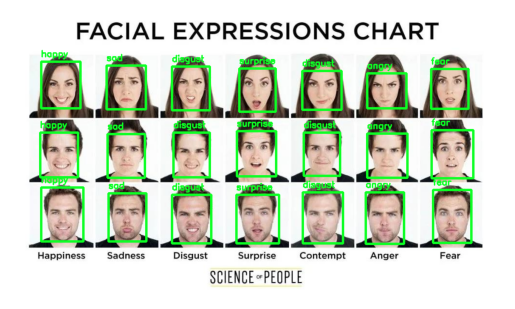

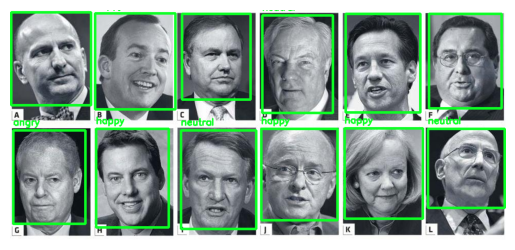

In [3]:
from dataset import COCODatasetBuilder
from imagewrapper import CVImageWrapper, ImageIterator

from pathlib import Path
from matplotlib import pyplot

import numpy as np
import os

test_ann_path = ds_p.annotation_files['test']
test_ds = COCODatasetBuilder.build_from_file(test_ann_path)

for img_path in ImageIterator(ds_p.images_dir['test']):
    img = CVImageWrapper(img_path)
    
    tuples = test_ds.get_bbox(Path(img_path).name)
    labels = [label for label, _ in tuples]
    bboxes = np.array([bbox for _, bbox in tuples])
    img.annotate(bboxes, labels)
    img.imshow(pyplot)

# Test VOC project format

In [4]:
from robowrapper import RoboProj

proj_template =  RoboProj(
    rf, 
    rf_proj=rf.project('nitesh-c-eszzc/fer_wider_face_template')
)
ds_template = proj_template.download(
    dataset_path=ROBOFLOW_ROOT_DIR+'/fer_wider_face_template',
    dataset_format='coco')


Extracting Dataset Version Zip to ./.data/robo/fer_wider_face_template in coco:: 100%|██████████| 6/6 [00:00<00:00, 221.35it/s]


In [13]:
import shutil
from robowrapper import RoboVOCDataset
from robowrapper import RoboProjCreator

from imagewrapper import ImageIterator

from dataset import COCODatasetBuilder, VOCDatasetBuilder

voc_root_dir_name = (Path(ds_template.root_dir).name + '_voc').replace('_', '-')
voc_root_dir = str(Path(ds_template.root_dir).parent / voc_root_dir_name)

ds_voc = RoboVOCDataset(voc_root_dir)
ds_voc.create_tag('test')
voc_test_dir = ds_voc.get_all_images_dir()[0] #only one tag

coco_ds = COCODatasetBuilder.build_from_file(ds_template.get_all_labels_dir()[0])
voc_ds_builder = VOCDatasetBuilder()
for img_path in ImageIterator(ds_template.get_all_images_dir()[0]):
    img_name = Path(img_path).name
    
    voc_img_name = img_name.split('_jpg')[0]+Path(img_path).suffix
    voc_img_path = voc_test_dir+'/'+voc_img_name
    shutil.copy(img_path, voc_img_path)
    voc_ds_builder.add_image(voc_img_path)
    anns = coco_ds.get_bbox(img_name)
    for label, bbox in anns:
        voc_bbox = np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]])
        voc_ds_builder.add_annotation(voc_img_name, label, voc_bbox)

# generate label files & refresh the RoboVOCDataset
voc_ds_builder.build().to_file(voc_test_dir)
ds_voc = RoboVOCDataset(ds_voc.root_dir)

proj_test = RoboProjCreator(rf, proj_name=voc_root_dir_name).create()
proj_test.upload(ds_voc)

loading Roboflow workspace...
loading Roboflow project...
image already annotated: .data/robo/fer-wider-face-template-voc/test/fer_wider_face_sample1.xml
image already annotated: .data/robo/fer-wider-face-template-voc/test/fer_wider_face_sample.xml


# Create a Project from Template
The template has sample image with all the facial expressions. By copying from the template, the project's labels will be same when we upload the annotations.

roboflow doesn't have an api to upload annotation with label names in yolo format.

In [4]:
from robowrapper import RoboProj

proj_template =  RoboProj(
    rf, 
    rf_proj=rf.project('nitesh-c-eszzc/fer_wider_face_template')
)
ds_template = proj_template.download(
    dataset_path=ROBOFLOW_ROOT_DIR+'/fer_wider_face_template')

Dependency ultralytics==8.0.134 is required but found version=8.0.178, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to ./.data/robo/fer_wider_face_template in yolov8:: 100%|██████████| 10/10 [00:00<00:00, 1844.30it/s]


In [5]:
from robowrapper import RoboProjCreator

# create test project and upload the files from template
proj_test = RoboProjCreator(rf, proj_name='test').create()
proj_test.upload(ds_template)

loading Roboflow workspace...
loading Roboflow project...
Duplicate image not uploaded: ./.data/robo/fer_wider_face_template/test/images/fer_wider_face_sample_jpg.rf.5bced443620d61f66d91c6e02e806429.jpg
image already annotated: .data/robo/fer_wider_face_template/test/labels/fer_wider_face_sample_jpg.rf.5bced443620d61f66d91c6e02e806429.txt
Duplicate image not uploaded: ./.data/robo/fer_wider_face_template/test/images/fer_wider_face_sample1_jpg.rf.0fbbf50874cf5304bd04226d56b942ad.jpg
image already annotated: .data/robo/fer_wider_face_template/test/labels/fer_wider_face_sample1_jpg.rf.0fbbf50874cf5304bd04226d56b942ad.txt


# Fix the bounding box issue
There was an issue with the bounding box (bbox) normalization, over the top of it I labeled the facial expressions. I need to fix the bounding box positions.

For some reason, the roboflow shows the location of bbox on their site. I am thinking it is applying some logic.

In [6]:
from widerface import WiderFaceManager
from widerface import WiderFaceAnnSearcher
from robowrapper import RoboProj


proj_fer =  RoboProj(rf, 
    rf_proj=rf.project('nitesh-c-eszzc/fed_wider_face_mini'),
    proj_ver=1
)
ds_fer = proj_fer.download(
    dataset_path=ROBOFLOW_ROOT_DIR+'/fed_wider_face_mini')

wface_anns = WiderFaceAnnSearcher(WiderFaceManager().get_val_reader().read())

Dependency ultralytics==8.0.134 is required but found version=8.0.178, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to ./.data/robo/fed_wider_face_mini in yolov8:: 100%|██████████| 616/616 [00:00<00:00, 777.31it/s]


# Update bbox coordinates
- Find the matcing image in widerface 
- Get the bboxes and normalize them
- Update the dataset on robo

In [8]:
import os
import shutil
from pathlib import Path
import numpy as np

from imagewrapper import CVImageWrapper
from imagewrapper import AnnFileReader
from imagewrapper import ImageIterator

from dataset import VOCDatasetBuilder
from robowrapper import RoboVOCDataset

os.makedirs(ds_fer.root_dir+'/voc', exist_ok=True)
ds_test = RoboVOCDataset(root_dir=ds_fer.root_dir+'/voc')

for (tag, img_dir, ann_dir) in ds_fer.get_tuples():
    ds = VOCDatasetBuilder()
    ds_test.create_tag(tag)
    
    for img_path in ImageIterator(img_dir):
        img_name = Path(img_path).name
        ann_path = str(Path(ann_dir) / img_name.replace(
                    Path(img_name).suffix, '.txt'))
        
        img = CVImageWrapper(img_path)
        wf_img_name = img_name.split('_jpg')[0]+'.jpg'
        df = wface_anns.search(wf_img_name)
        bboxes = df[['x', 'y', 'w', 'h']].to_numpy()
        
        anns = AnnFileReader(ann_path).read()
        if len(anns) == 0:
            anns = np.zeros((bboxes.shape[0], bboxes.shape[1]+1))
        anns[:, 1:] = bboxes
        
        img_id = ds.add_image(img_path)
        for ann in anns:
            bbox = [ann[1], ann[2], ann[1]+ann[3], ann[2]+ann[4]]
            ds.add_annotation(img_id, ds_fer.get_labels()[int(ann[0])], bbox)
        
        shutil.copyfile(img_path, ds_test.images_dir[tag]+'/'+img_name)
        
        #Rename image and label - roboflow is able to handle it.
        # os.rename(img_path, img_dir + '/' + wf_img_name)
        # os.rename(ann_path, ann_path + '/' + wf_img_name.replace(
        #     Path(wf_img_name).suffix, '.txt'))
    
    ds.build().to_file(ds_test.images_dir[tag]+'/_annotations.coco.json')

# constructing RoboCOCODataset again will refresh the object
ds_test = RoboCOCODataset(ds_test.root_dir)
#proj_test.upload(ds_test)

./.data/robo/fed_wider_face_mini/coco/val/_annotations.coco.json ERROR saving annotation: save annotation for nfe2ztYPMC6PUw9MXVuY / bad response: 400: {'message': 'Unrecognized annotation format.', 'type': 'InvalidAnnotationFormat', 'hint': 'We were unable to parse your annotation format or it is not supported via the upload API at this time. Ensure that the annotations file provided in the request contains annotations for the provided image.', 'annotation': {'info': {'type': 'unknown', 'format': 'json'}}}
./.data/robo/fed_wider_face_mini/coco/val/_annotations.coco.json ERROR saving annotation: save annotation for aQfXOUG1Dgzqs9Jmnwth / bad response: 400: {'message': 'Unrecognized annotation format.', 'type': 'InvalidAnnotationFormat', 'hint': 'We were unable to parse your annotation format or it is not supported via the upload API at this time. Ensure that the annotations file provided in the request contains annotations for the provided image.', 'annotation': {'info': {'type': 'unkn

# Test
Test the match criteria to find the image in  widerface & normalize the bboxes to upate the dataset

In [ ]:
from widerface import WiderFaceManager
from widerface import WiderFaceAnnSearcher

wface_anns = WiderFaceAnnSearcher(WiderFaceManager().get_val_reader().read())

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

from imagewrapper import CVImageWrapper
from imagewrapper import AnnFileReader

label_tags = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

img_name = '0_Parade_marchingband_1_267_jpg.rf.9eb58c2416e231d227c0f18e7f1cd861.jpg'
ann_path = '/Users/n0c09jf/code/github/tryml/notebooks/cv/group-emotion/.data/robo/nitesh-c-eszzc/fed_wider_face_mini/1/valid/labels/0_Parade_marchingband_1_267_jpg.rf.9eb58c2416e231d227c0f18e7f1cd861.txt'
img_dir = Path(ann_path).parent.parent / 'images'
ann_name = Path(ann_path).parts[-1]
img_path = str(Path(img_dir) / ann_name.replace(
                    Path(ann_name).suffix, '.jpg'))
img = CVImageWrapper(img_path)
anns = AnnFileReader(ann_path).read()
bboxes = img.denormalize_bboxes(anns[:, 1:])
labels = [ label_tags[int(x)] for x in anns[:, 0] ]

wf_anns_df = wface_anns.search(img_name.split('_jpg')[0]+'.jpg')
wf_anns = wf_anns_df[['x', 'y', 'w', 'h']].to_numpy()


wf_img = CVImageWrapper('/Users/n0c09jf/code/github/tryml/notebooks/cv/group-emotion/.data/wider_face/images/WIDER_val/images/0--Parade/0_Parade_marchingband_1_267.jpg')
wf_img.annotate(bboxes, labels)
wf_img.imshow(plt)

# normalize & de-normalize and check if bboxes looks good
wf_img.load()
wf_img.annotate(wf_img.denormalize_bboxes(wf_img.normalize_bboxes(wf_anns)), labels)
wf_img.imshow(plt)